<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd

In [2]:
def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]
def myLoadImage(i, im_files, augment=True) :
    f = im_files[i]
    im = cv2.imread(f)
    h0, w0 = im.shape[:2]
    r = img_size / max(h0, w0)
    if r != 1:  # if sizes are not equal
        interp = cv2.INTER_LINEAR if augment else cv2.INTER_AREA  # random.choice(self.rand_interp_methods)
        im = cv2.resize(im, (int(w0 * r), int(h0 * r)), interpolation=interp)
    return im, (h0, w0), im.shape[:2] 
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y
def xyxy2xywhn(x, w=640, h=640, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_coords(x, (h - eps, w - eps))  # warning: inplace clip
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y
def noPad(label, xc, yc, xmin, ymin) :
    label4_ = label.copy()
    if ((xc>s) & (yc<s)) :
        label4_[:,1] = label4_[:,1] - xmin
        label4_[:,3] = label4_[:,3] - xmin
    elif ((xc<s) & (yc>s)) :
        label4_[:,2] = label4_[:,2] - ymin
        label4_[:,4] = label4_[:,4] - ymin
    elif ((xc>s) & (yc>s)) :
        label4_[:,1] = label4_[:,1] - xmin
        label4_[:,3] = label4_[:,3] - xmin
        label4_[:,2] = label4_[:,2] - ymin
        label4_[:,4] = label4_[:,4] - ymin
    return label4_

In [56]:
def myMosaic(img_size, path, form = "xyxy") :
    labels4 = []
    s = img_size
    mosaic_border = [-img_size // 2, -img_size // 2]
    print(f'mosaic_border : {mosaic_border}')

    # center point
    yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in mosaic_border)  # mosaic center x, y # 81 172
    print(f'yc, xc : {yc, xc}')
    # image files and labels
    # train set & not Scratch
    im_files = np.array([i for i in os.listdir(path) if i.endswith("png")], dtype = "object")
    print(f'im_files : {im_files}')
    im_files = list(path + "/" + im_files)
    print(f'im_files : {im_files}')
    label_files = img2label_paths(im_files) 
    print(f'label_files : {label_files}')

    n = len(im_files)
    print(f'n : {n}')
    indices_ = range(n)
    print(f'indices_ : {indices_}')

    # random 4 images
    indices = random.choices(indices_, k=4)  # 3 additional image indices # [0, 3292, 20762, 18713]
    print(f'indices : {indices}')

    random.shuffle(indices)  # [18713, 0, 20762, 3292]

    for i, index in enumerate(indices):
        # Load image
        img, (h0, w0), (h, w) = myLoadImage(index,im_files)
        print(f'img : {img.shape}')
        print(f'i : {i}')
        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

            xmin, ymin = x1a, y1a

        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            xmax, ymax = x2a, y2a

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        labels = np.loadtxt(label_files[index], ndmin=2)

        if labels.size:
            labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            labels[labels < 0] = 0
            labels[labels > s*2] = s*2
        labels4.append(labels)

    # Concat/clip labels
    labels4 = np.concatenate(labels4, 0)

    # no padding
    img4 = img4[ymin:ymax, xmin:xmax,:]
#     labels4 = noPad(labels4, xc, yc, xmin, ymin)

    # resize
    img4 = cv2.resize(img4, (w,h))
    labels4[:,1:] = xyxy2xywhn(labels4[:,1:], w = xmax - xmin, h = ymax-ymin)
    labels4 = labels4[labels4[:,3]>0]
    labels4 = labels4[labels4[:,4]>0]
    
    if form == "xyxy" :
        labels4[:,1:] = xywhn2xyxy(labels4[:,1:], w = img4.shape[1], h = img4.shape[0])
    
    return img4, labels4


In [57]:
from PIL import Image, ImageDraw
import matplotlib.patches as patches
def myFig(img, bbox, drawB = True) :
    image = Image.fromarray(img,"RGB")
    draw = ImageDraw.Draw(image)

    if drawB :
        for i in range(len(bbox)) :
            xmin = bbox[i][1] 
            ymin = bbox[i][2]
            xmax = bbox[i][3]
            ymax = bbox[i][4]

            draw.rectangle((xmin, ymin, xmax, ymax), outline=(255,0,0), width = 1) # bounding box
#     display(image)
    return image

In [58]:
img_size = 64
# path = '/data/ij/Mosaic_data_augmentation_YOLO/coco128/images/train2017'
path = '/data/ij/Mosaic_data_augmentation_YOLO/images'

mosaic_border : [-32, -32]
yc, xc : (78, 71)
im_files : ['generated_image_573.png' 'generated_image_817.png'
 'generated_image_287.png' 'generated_image_592.png'
 'generated_image_62.png' 'generated_image_541.png'
 'generated_image_393.png' 'generated_image_521.png'
 'generated_image_803.png' 'generated_image_559.png'
 'generated_image_566.png' 'generated_image_127.png'
 'generated_image_530.png' 'generated_image_872.png'
 'generated_image_280.png' 'generated_image_597.png'
 'generated_image_694.png' 'generated_image_708.png'
 'generated_image_442.png' 'generated_image_739.png'
 'generated_image_319.png' 'generated_image_136.png'
 'generated_image_434.png' 'generated_image_876.png'
 'generated_image_185.png' 'generated_image_469.png'
 'generated_image_773.png' 'generated_image_264.png'
 'generated_image_433.png' 'generated_image_556.png'
 'generated_image_568.png' 'generated_image_740.png'
 'generated_image_295.png' 'generated_image_377.png'
 'generated_image_899.png' 'generated_image_

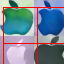

In [59]:
im, la = myMosaic(img_size, path)
print(im.shape)
myFig(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), la)

<br> 
setting

In [168]:
img_size = 64
# path = '/data/ij/Mosaic_data_augmentation_YOLO/coco128/images/train2017'
path = '/data/ij/Mosaic_data_augmentation_YOLO/images'

In [169]:
labels4 = [] # 최종 output image 
s = img_size
mosaic_border = [-img_size // 2, -img_size // 2]

In [170]:
mosaic_border

[-32, -32]

<br> 
image files and label files

In [171]:
im_files = np.array([i for i in os.listdir(path) if i.endswith("png")], dtype = "object")
im_files = list(path + "/" + im_files)

In [172]:
im_files[:10]

['/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_573.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_817.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_287.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_592.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_62.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_541.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_393.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_521.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_803.png',
 '/data/ij/Mosaic_data_augmentation_YOLO/images/generated_image_559.png']

In [173]:
label_files = img2label_paths(im_files) 

In [174]:
label_files[:10]

['/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_573.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_817.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_287.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_592.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_62.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_541.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_393.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_521.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_803.txt',
 '/data/ij/Mosaic_data_augmentation_YOLO/labels/generated_image_559.txt']

<br> 
length of files

In [175]:
n = len(im_files)
indices_ = range(n)

In [176]:
print(indices_)

range(0, 534)


<br> 
4 image center poing

In [177]:
# center point
# random.seed(1)
yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in mosaic_border)  

In [178]:
print(yc, xc)

32 74


<br> 
choice random 4 images and shuffle

In [179]:
# random 4 images
indices = random.choices(indices_, k=4)  # 3 additional image indices # [0, 3292, 20762, 18713]
random.shuffle(indices)  # [18713, 0, 20762, 3292]

In [180]:
print(indices)

[190, 303, 360, 120]


<br> 
create mosaic image

In [240]:
for i, index in enumerate(indices):
    print(f'i : {i}')
    print(f'index : {index}')
    # Load image
    img, (h0, w0), (h, w) = myLoadImage(index,im_files)

    # place img in img4
    if i == 0:  # top left
        img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

        xmin, ymin = x1a, y1a

    elif i == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif i == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
    elif i == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        xmax, ymax = x2a, y2a

    img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
    padw = x1a - x1b
    padh = y1a - y1b

    # Labels
    labels = np.loadtxt(label_files[index], ndmin=2)

    if labels.size:
        labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
        labels[labels < 0] = 0
        labels[labels > s*2] = s*2
    labels4.append(labels)

i : 0
index : 190
i : 1
index : 303
i : 2
index : 360
i : 3
index : 120


<br>
<hr>
details

<br> 
i=0

In [249]:
img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8) 

(128, 128, 3)


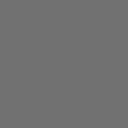

In [250]:
print(img4.shape)
Image.fromarray(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))

In [251]:
labels4 = [] # 최종 output image 
i = 0
index = indices[i]

In [252]:
img, (h0, w0), (h, w) = myLoadImage(index,im_files)


In [310]:
# print(h0, w0)
# print(h, w)

mosaic_border = [img_size // 2, img_size // 2]
print(mosaic_border)
print(s)

yc, xc = (int(random.uniform(64, 2 * s)) for x in mosaic_border)  
print(yc, xc)

[32, 32]
64
75 95


In [314]:
# place img in img4

if i == 0:  # top left
    img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
    x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
    x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

    xmin, ymin = x1a, y1a


64
0 64 0 64
11 75 31 95


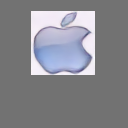

In [315]:
print(s)
print(y1b, y2b, x1b,x2b)
print(y1a,y2a,x1a,x2a)
# img4[0:64, x1a:x2a] = img[0:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]
Image.fromarray(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))

In [317]:
img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels = np.loadtxt(label_files[index], ndmin=2)
print(f'labels : {labels}')
print(f'labels.size : {labels.size}')
if labels.size:
    labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels[labels < 0] = 0
    labels[labels > s*2] = s*2
    print(f'labels : {labels}')
labels4.append(labels)

labels : [[0.  0.5 0.5 1.  1. ]]
labels.size : 5
labels : [[ 0. 31. 11. 95. 75.]]


labels_ : [[0.  0.5 0.5 1.  1. ]]
labels_ : [[ 0.  0.  0. 64. 64.]]


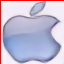

In [318]:
labels_ = np.loadtxt(label_files[index], ndmin=2)
print(f'labels_ : {labels_}')
labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
print(f'labels_ : {labels_}')
myFig(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels_)

labels : [[ 0. 31. 11. 95. 75.]]


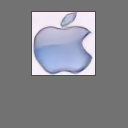

In [319]:
print(f'labels : {labels}')
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels)

<br> 
i=1

In [191]:
i = 1
index = indices[i]

img, (h0, w0), (h, w) = myLoadImage(index,im_files)

x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels = np.loadtxt(label_files[index], ndmin=2)

if labels.size:
    labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels[labels < 0] = 0
    labels[labels > s*2] = s*2
labels4.append(labels)

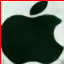

In [192]:
labels_ = np.loadtxt(label_files[index], ndmin=2)
labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
myFig(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels_)

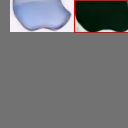

In [193]:
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels)

<br> 
i=2

In [194]:
i = 2
index = indices[i]

img, (h0, w0), (h, w) = myLoadImage(index,im_files)

x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels = np.loadtxt(label_files[index], ndmin=2)

if labels.size:
    labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels[labels < 0] = 0
    labels[labels > s*2] = s*2
labels4.append(labels)

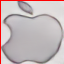

In [195]:
labels_ = np.loadtxt(label_files[index], ndmin=2)
labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
myFig(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels_)

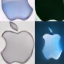

In [207]:
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels)

<br> 
i=3

In [197]:
i = 3
index = indices[i]

img, (h0, w0), (h, w) = myLoadImage(index,im_files)

x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

xmax, ymax = x2a, y2a

img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels = np.loadtxt(label_files[index], ndmin=2)

if labels.size:
    labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels[labels < 0] = 0
    labels[labels > s*2] = s*2
labels4.append(labels)

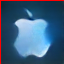

In [198]:
labels_ = np.loadtxt(label_files[index], ndmin=2)
labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
myFig(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels_)

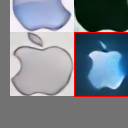

In [199]:
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels)

<hr> 
<br>

<br> 
labels

In [200]:
# Concat/clip labels
labels4 = np.concatenate(labels4, 0)

In [201]:
labels4

array([[  0.,  10.,   0.,  74.,  32.],
       [  0.,  74.,   0., 128.,  32.],
       [  0.,  10.,  32.,  74.,  96.],
       [  0.,  74.,  32., 128.,  96.]])

<br> 
no padding

In [202]:
# no padding
img4 = img4[ymin:ymax, xmin:xmax,:]
labels4 = noPad(labels4, xc, yc, xmin, ymin)

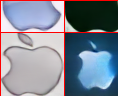

In [203]:
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels4)

<br> 
resize

In [204]:
img4 = cv2.resize(img4, (w,h))
labels4[:,1:] = xyxy2xywhn(labels4[:,1:], w = xmax - xmin, h = ymax-ymin)
labels4 = labels4[labels4[:,3]>0]
labels4 = labels4[labels4[:,4]>0]
labels4[:,1:] = xywhn2xyxy(labels4[:,1:], w = img4.shape[1], h = img4.shape[0])

(64, 64, 3)


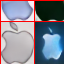

In [205]:
print(img4.shape)
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels4)